In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [2]:
# Baseline parameters
omgM0 = 0.298
M_b0 = -19.3
alpha0 = 0.15424  #  alpha0         =    0.15424 +-  0.00553   
beta0 = 3.02371   #  beta0          =    3.02371 +-  0.06431   
gamma0 = 0.05271  #  gamma0         =    0.05271 +-  0.00917 
m_step = 10.13
tau = 0.001

In [3]:
# Distance modulus for the observational data, delta_b taken from data directly
def muexp(mb, x1, color, Mstell, delta_b):
    mu=[]
    for i in range(len(mb)):
        delta_M = gamma0 / (1 + np.exp(-(Mstell[i]-m_step)/tau))
        mu.append(mb[i] - M_b0 + alpha0*x1[i] - beta0*color[i] + delta_M - delta_b[i])
    return mu

In [4]:
# Distance modulus for the observational data, delta_b calculated from delta_{mb,x1,c}
def muexp_db(mb, x1, color, Mstell, delta_mb, delta_x1, delta_c):
    mu=[]
    for i in range(len(mb)):
        delta_M = gamma0 / (1 + np.exp(-(Mstell[i]-m_step)/tau))
        delta_b = delta_mb[i] - beta0*delta_c[i] + alpha0*delta_x1[i]
        mu.append(mb[i] - M_b0 + alpha0*x1[i] - beta0*color[i] + delta_M - delta_b)
    return mu

In [5]:
if __name__=='__main__':
    
    # Read Pantheon data
    filename_G10 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
#     filename_C11 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-c11.fitres'

    # Read LCs parameters for outlier supernovae
    filename_outliers = '../data/FITOPT000.FITRES'

    SNdata = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")  
    SNoutliers = pandas.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

    SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
    SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
    SNoutliers['wt_c'] = 1./SNoutliers['cERR']**2
    
### simple mean

#     df = SNoutliers.groupby(['CID'], as_index=False).mean()
#     for i in df['CID']:
#         try:
#             ind = SNdata.loc[SNdata['CID'] == i].index[0]
#             SNdata.loc[ind,'zCMB'] = df[df['CID'] == i].iloc[0]['zCMB']
#             SNdata.loc[ind,'zHD'] = df[df['CID'] == i].iloc[0]['zHD']
#             SNdata.loc[ind,'HOST_LOGMASS'] = df[df['CID'] == i].iloc[0]['HOST_LOGMASS']
#             SNdata.loc[ind,'x1'] = df[df['CID'] == i].iloc[0]['x1']
#             SNdata.loc[ind,'c'] = df[df['CID'] == i].iloc[0]['c']
#             SNdata.loc[ind,'mB'] = df[df['CID'] == i].iloc[0]['mB']
#         except Exception:
#             continue

### weighted mean

    grouped = SNoutliers.groupby(['CID'], as_index=False)

    def wavg_mb(group):
        d = group['mB']
        w = group['wt_mb']
        return (d * w).sum() / w.sum()
    
    def wavg_x1(group):
        d = group['x1']
        w = group['wt_x1']
        return (d * w).sum() / w.sum()
    
    def wavg_c(group):
        d = group['c']
        w = group['wt_c']
        return (d * w).sum() / w.sum()

    df_mb = grouped.apply(wavg_mb)
    df_x1 = grouped.apply(wavg_x1)
    df_c = grouped.apply(wavg_c)

    for i in df_mb['CID']:
        try:
            ind = SNdata.loc[SNdata['CID'] == i].index[0]
            SNdata.loc[ind,'mB'] = df_mb[(df_mb['CID'] == i)].values[0][1]
            SNdata.loc[ind,'x1'] = df_x1[(df_x1['CID'] == i)].values[0][1]
            SNdata.loc[ind,'c'] = df_c[(df_c['CID'] == i)].values[0][1]
        except Exception:
            continue


    sn_name = SNdata['CID']
    zcmb = SNdata['zCMB']
    zhel = SNdata['zHD']
    mb = SNdata['mB']
    x1 = SNdata['x1']
    color = SNdata['c']
    Mstell = SNdata['HOST_LOGMASS']
    mu = SNdata['MU']
    mu_model = SNdata['MUMODEL']
    mu_err = SNdata['MUERR']
    mu_res = SNdata['MURES']
    dataset = SNdata['IDSAMPLE']
    delta_mb = SNdata['biasCor_mB'] 
    delta_c = SNdata['biasCor_c'] 
    delta_x1 = SNdata['biasCor_x1'] 
    delta_b = SNdata['biasCor_mu']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


<IPython.core.display.Javascript object>


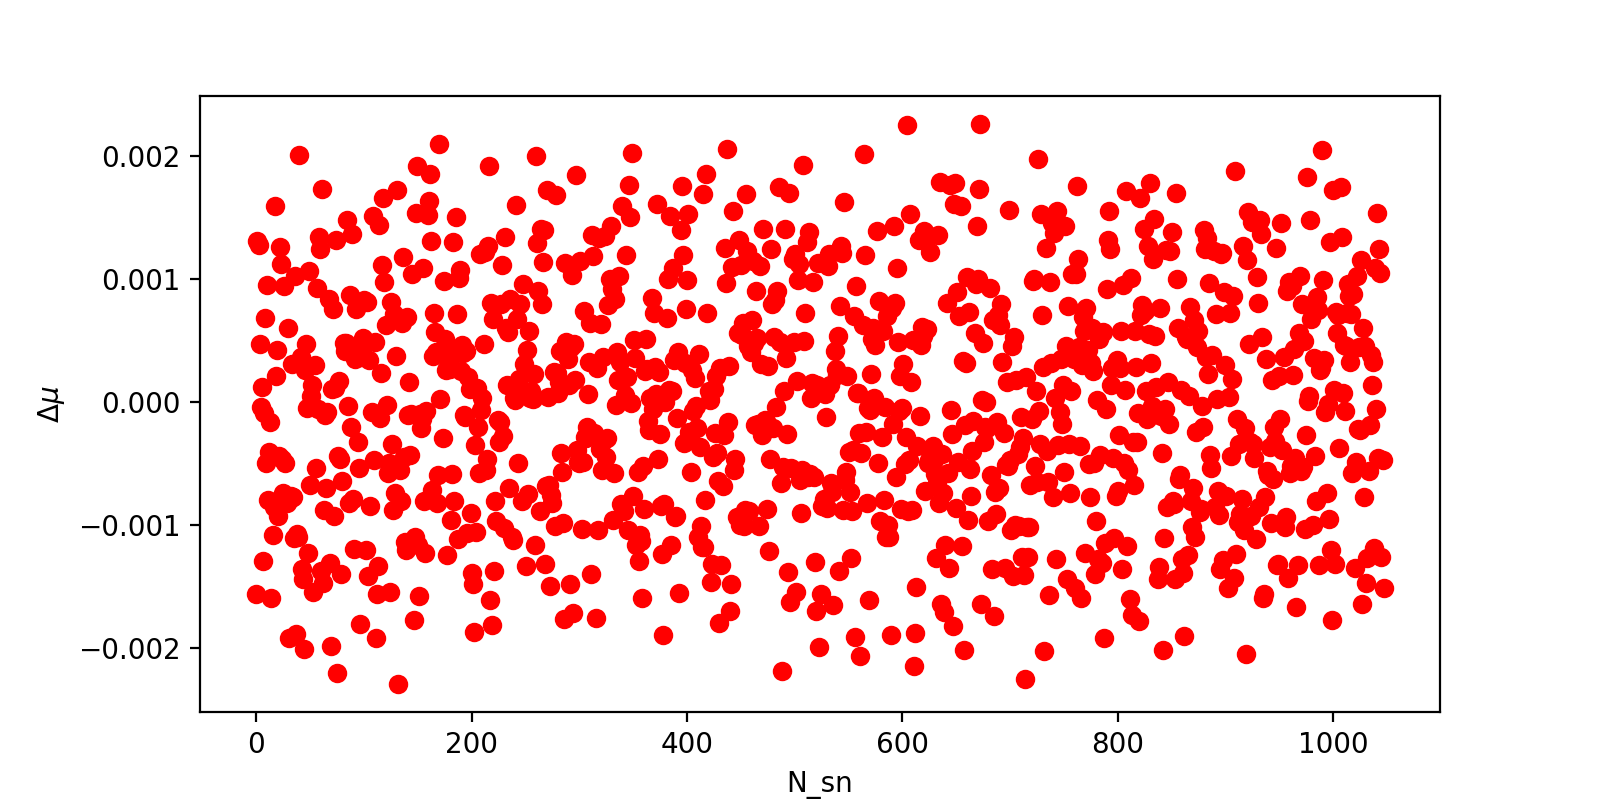

Text(0, 0.5, '$\\Delta\\mu$')

In [6]:
# Comparison between muexp and muexp_db
SNdata['mu_exp'] = muexp(mb, x1, color, Mstell, delta_b)
SNdata['mu_exp_db'] = muexp_db(mb, x1, color, Mstell, delta_mb, delta_x1, delta_c)

# Diff plot
fig = plt.figure(figsize=[8,4])
ax  = fig.add_subplot(111)
ax.plot(SNdata['mu_exp'] - SNdata['mu_exp_db'], 'ro')
ax.set_xlabel("N_sn")
ax.set_ylabel(r'$\Delta\mu$')


<IPython.core.display.Javascript object>


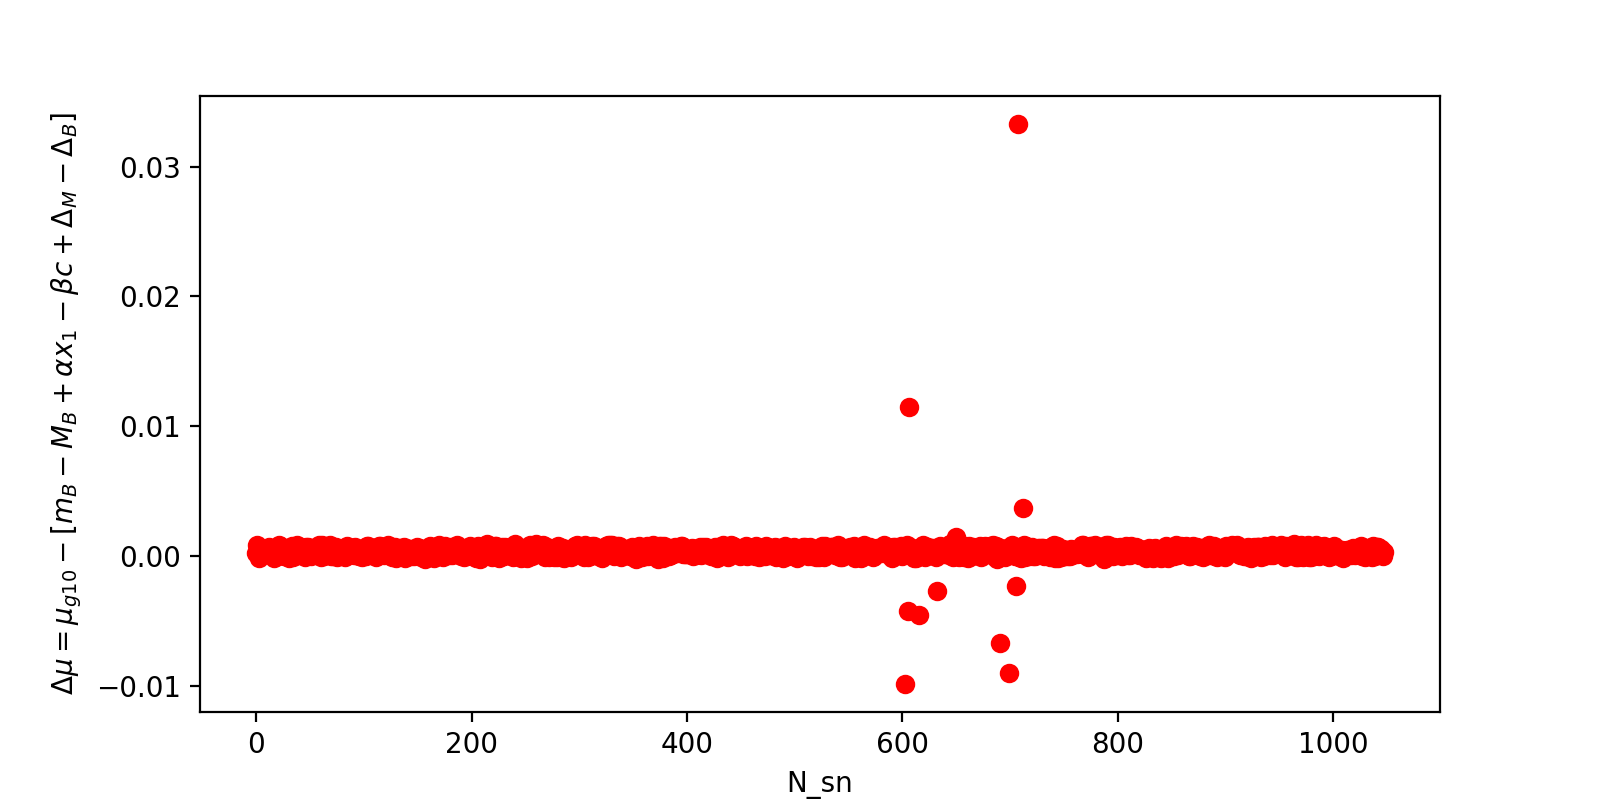

In [7]:
# Diff plot
mu_exp = SNdata['mu_exp']
mu_exp_db = SNdata['mu_exp_db']
diff = mu_exp - mu

fig = plt.figure(figsize=[8,4])
ax  = fig.add_subplot(111)
ax.plot(diff, 'ro')
ax.set_xlabel("N_sn")
ax.set_ylabel(r'$\Delta\mu = \mu_{g10} - [m_B - M_B + \alpha x_1 - \beta c + \Delta_M - \Delta_B]$')

plt.savefig('../plots/diff_g10.pdf')

In [8]:
diff = mu_exp - mu

for i,j in zip(diff,sn_name):
    if abs(i) > 0.005:
        print(j,i)

2005hc -0.00982740272229421
2005lu 0.011455516811729183
2004ef -0.0066644442710313
2005iq -0.009018489231969795
2006ev 0.033272750907734405


<IPython.core.display.Javascript object>


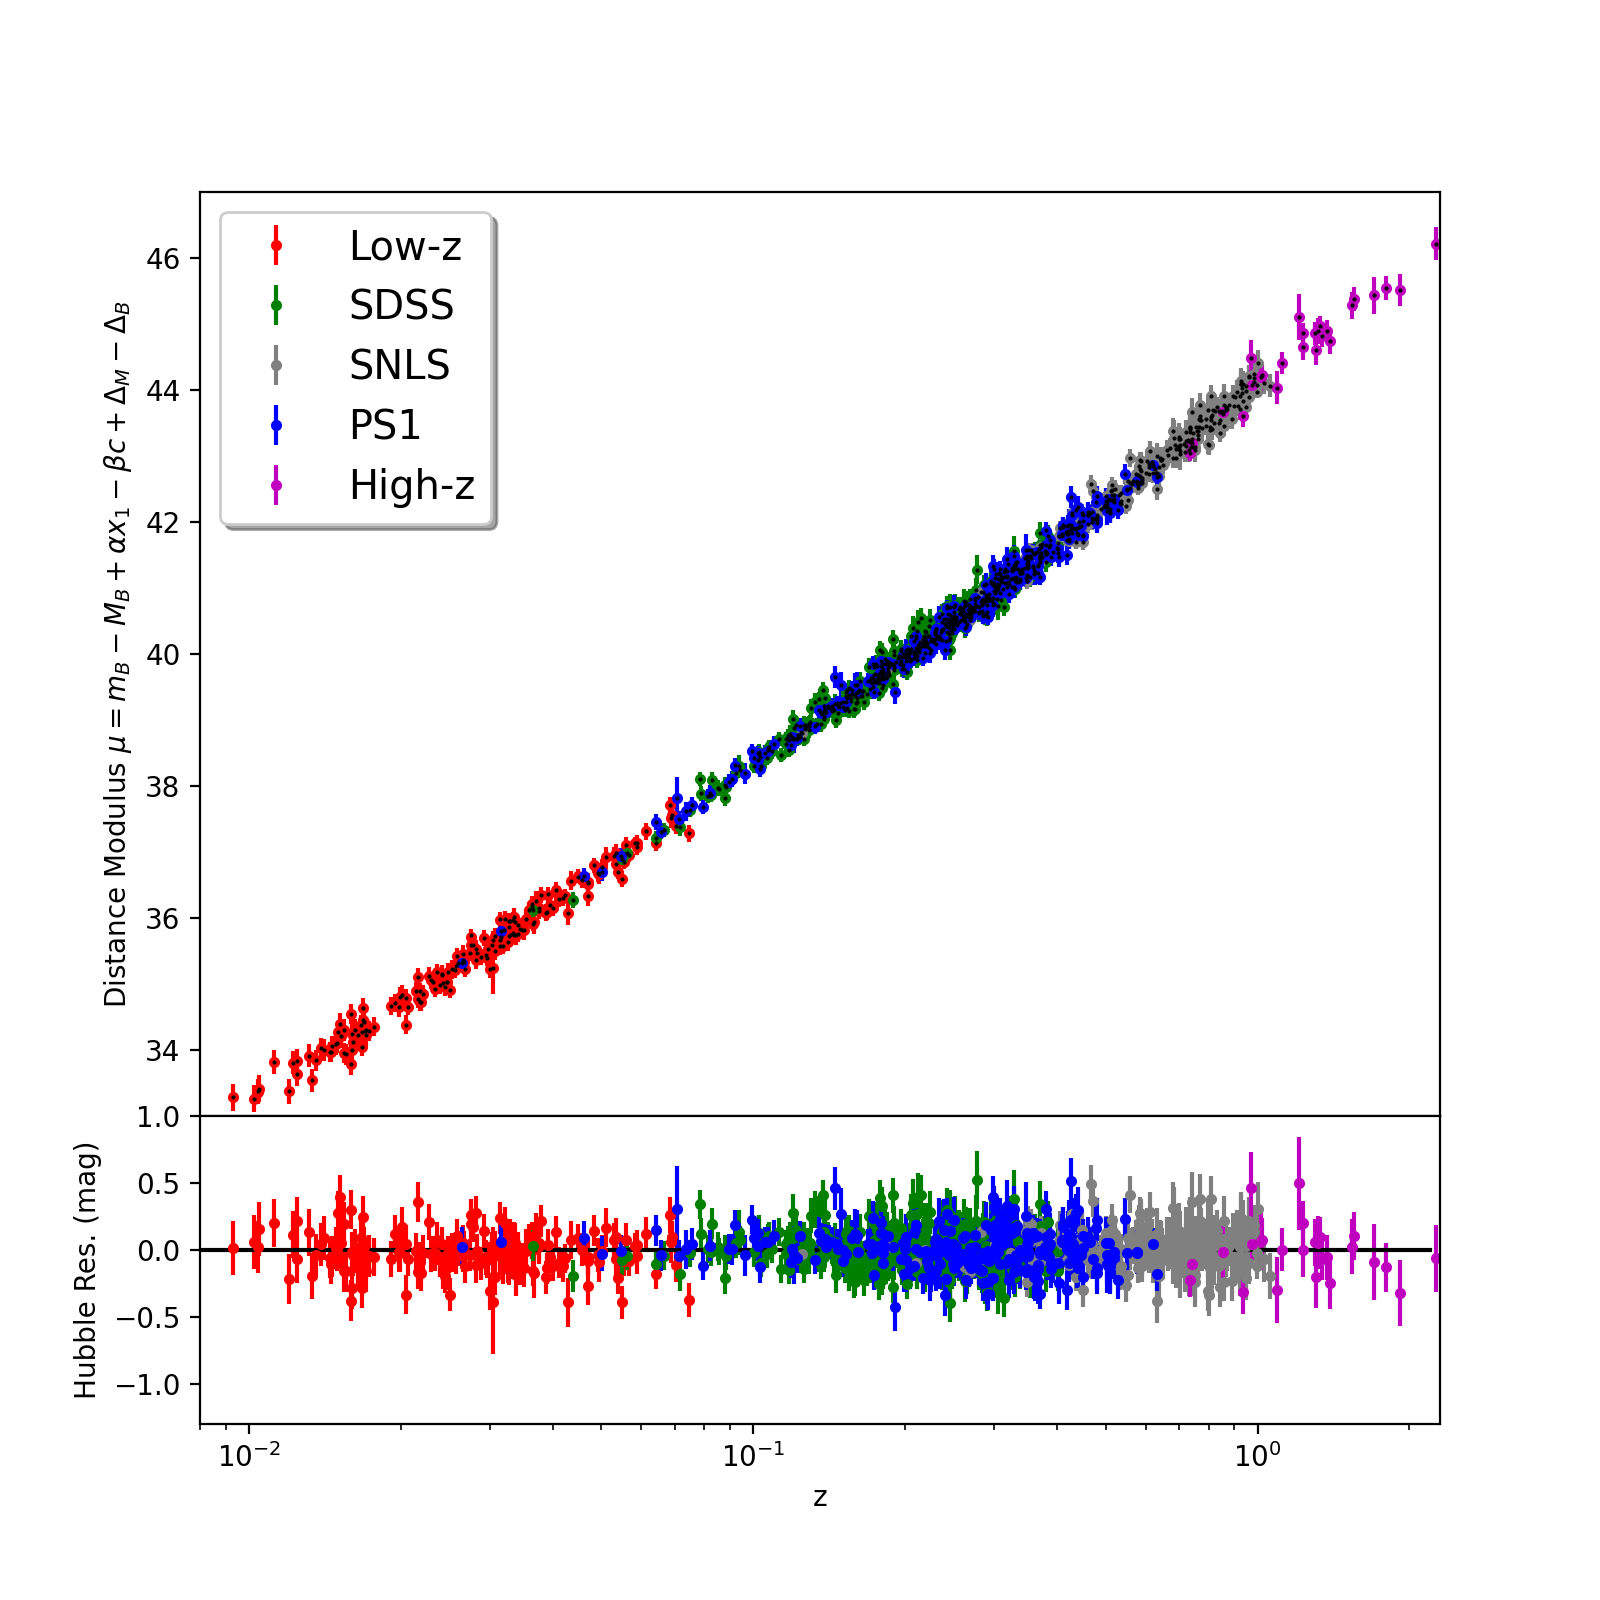

(-1.3, 1.0)

In [20]:
# Comparison of two distance modulus
setNB = dataset==0
setSDSS = dataset==2
setSNLS = dataset==3
setPS1 = dataset==1
setHST = dataset==4

x0 = np.linspace(0.001, 2.2, 1000)
y0 = np.zeros(len(x0))

fig = plt.figure(figsize=[8,8])
P1, P2 = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3,1]))
fig.subplots_adjust(hspace=0)

# Plot for mu calculated from G10 mb,x1,c,M_st,db parameters and baseline cosmology from Pantheon analysis
P1.plot(zcmb, mu_exp, marker='.', ms=1, color="black", linestyle="None", zorder=0)

# Plot for mu taken directly from G10
P1.errorbar(zcmb[setNB], mu[setNB], yerr=mu_err[setNB], marker='.', color="red", linestyle="None", 
            ecolor="red", label='Low-z', zorder=-1)
P1.errorbar(zcmb[setSDSS], mu[setSDSS], yerr=mu_err[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green", label='SDSS', zorder=-1)
P1.errorbar(zcmb[setSNLS], mu[setSNLS], yerr=mu_err[setSNLS], marker='.', color="grey", linestyle="None", 
            ecolor="grey", label='SNLS', zorder=-1)
P1.errorbar(zcmb[setPS1], mu[setPS1], yerr=mu_err[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue", label='PS1', zorder=-1)
P1.errorbar(zcmb[setHST], mu[setHST], yerr=mu_err[setHST], marker='.', color="m", linestyle="None", 
            ecolor="m", label='High-z', zorder=-1)


hd_res = SNdata['MU'] - SNdata['MUMODEL']

P2.errorbar(zcmb[setNB], hd_res[setNB], yerr=mu_err[setNB], marker='.', color="red", linestyle="None", 
            ecolor="red")
P2.errorbar(zcmb[setSDSS], hd_res[setSDSS], yerr=mu_err[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green")
P2.errorbar(zcmb[setSNLS], hd_res[setSNLS], yerr=mu_err[setSNLS], marker='.', color="grey", linestyle="None", 
            ecolor="grey")
P2.errorbar(zcmb[setPS1], hd_res[setPS1], yerr=mu_err[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue")
P2.errorbar(zcmb[setHST], hd_res[setHST], yerr=mu_err[setHST], marker='.', color="m", linestyle="None", 
            ecolor="m", label='High-z')
P2.plot(x0, y0, c="black", label="$\Lambda$CDM fit")

# plot settings
P1.set_ylabel(r'Distance Modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M - \Delta_B$')  
P1.set_xscale('log')
P1.set_ylim(33, 47)
P1.legend(loc='best', shadow=True, fontsize='x-large')
P2.set_xlabel('z')
P2.set_ylabel(r'Hubble Res. (mag)')  
P2.set_xscale('log')
P2.set_xlim(8e-3, 2.3)
P2.set_ylim(-1.3, 1)

<IPython.core.display.Javascript object>


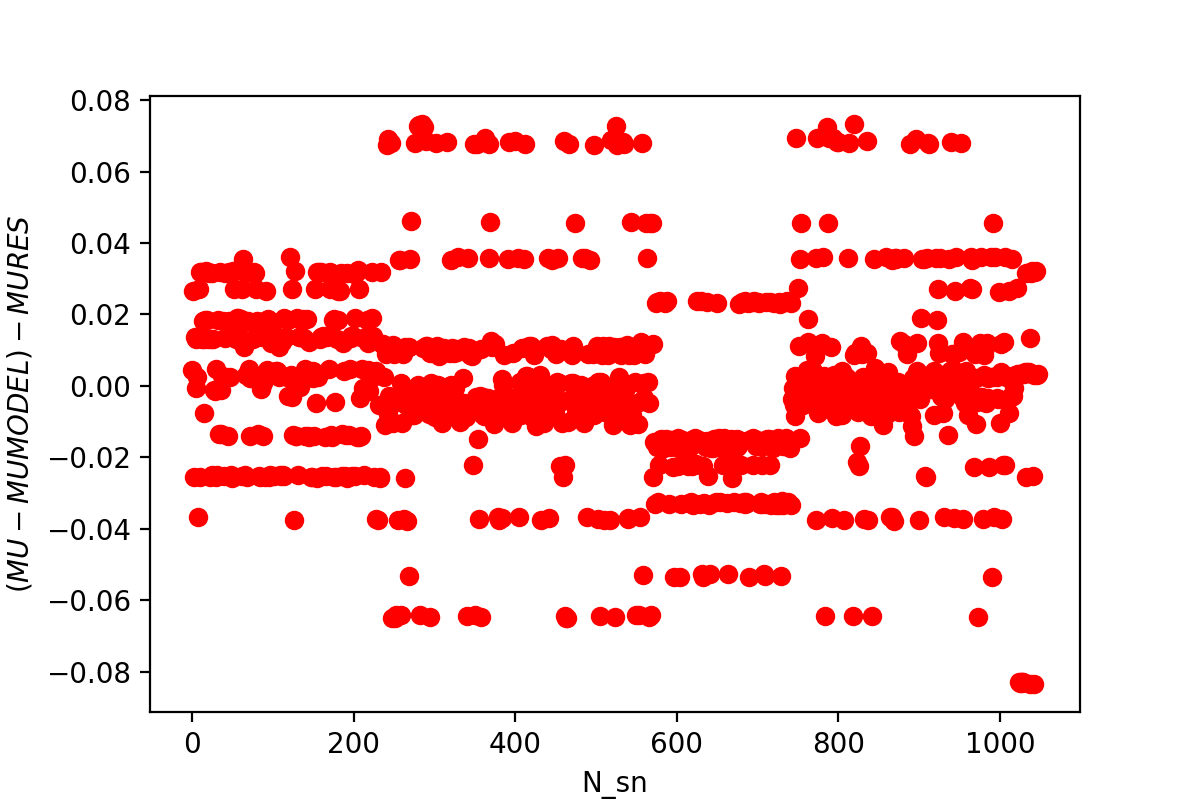

Text(0, 0.5, '$(MU-MUMODEL) - MURES$')

In [10]:
# Diff plot for residuals
hd_res = SNdata['MU'] - SNdata['MUMODEL']

fig = plt.figure(figsize=[6,4])
ax  = fig.add_subplot(111)
ax.plot(hd_res - mu_res, 'ro')
ax.set_xlabel("N_sn")
ax.set_ylabel(r'$(MU-MUMODEL) - MURES$') # from D.Scolnic mures=mu-mumodel-mumean